# (02) EDA y balanceo de target: Preparación para el modelado
habiendo imputado exitosamente los nulos del dataset, ahora se continuará con el análisis exploratorio y preparación para el entrenamiento del modelo.

* entorno: *imbalanced_data*

#### Objetivos: 
* continuar con el análisis exploratorio
* detectar relaciones no lineales
* arreglar la problemática de desbalancedo de datos en la predictora `income`
* preparación de los datos para el modelado


#### importación de librerías, módulos y dataset

In [1]:
# libraries
import matplotlib.pyplot as plt
import numpy   as np
import pandas  as pd
import pprint

from imblearn.over_sampling   import   SMOTE
#from imblearn.under_sampling  import  RandomUnderSampler
from sklearn.ensemble         import   RandomForestClassifier
from sklearn.model_selection  import   train_test_split as tts
from sklearn.metrics          import   classification_report
from sklearn.preprocessing    import  OneHotEncoder as OHE
from typing import List

# warnings (imblearn warning due to sklearn version)
import warnings

In [2]:
# own modules
from import_modules import import_to_nb

# plotting & eda functions
import_to_nb(directory= 'scripts', show_content= False)

# lists, dicts & auxiliar functions (for this notebook)
import_to_nb(directory= 'modules', show_content= False) 

#-# directory: scripts
from load_data import Loader
from utils     import Utils
from utils_initial_exploration     import InitialExploration
from utils_categorical_plots       import CategoricalPlots
from utils_classif_models_plots    import ClassifModelsPlots
from utils_numerical_plots         import NumericalPlots

#-# directory: modules
from module_imbalanced             import ImbalancedModule
from module_discarted_methods      import df_balanced_subsets

In [3]:
load          = Loader()
utils         = Utils()
initial_exp   = InitialExploration()
cat_plots     = CategoricalPlots()
classif_plots = ClassifModelsPlots()
num_plots     = NumericalPlots()
imb_methods   = ImbalancedModule()

In [4]:
# warnings: (debido al downgrade para usar imblearn)
warnings.simplefilter('ignore',  category= DeprecationWarning)
warnings.simplefilter('ignore',  category= FutureWarning)

In [5]:
# load appereance
utils.load_appereance()

In [6]:
df_clean = load.load_data(file_name= 'adult_imputed', copy= True)
df_clean[:3]

,occupation,workclass,native_country,age,fnlwgt,education,education_num,marital_status,relationship,ethnicity,genre,capital_gain,capital_loss,hours_per_week,income
0,adm_clerical,state_gov,USA,39,77516,bachelors,13,never_married,not_in_family,white,Male,2174,0,40,no
1,exec_managerial,self_emp_not_inc,USA,50,83311,bachelors,13,married_civ_spouse,husband,white,Male,0,0,13,no
2,handlers_cleaners,Private,USA,38,215646,hs_grad,9,divorced,not_in_family,white,Male,0,0,40,no


In [7]:
df_clean.isnull().sum().sum() #0

0

### inicio del análisis

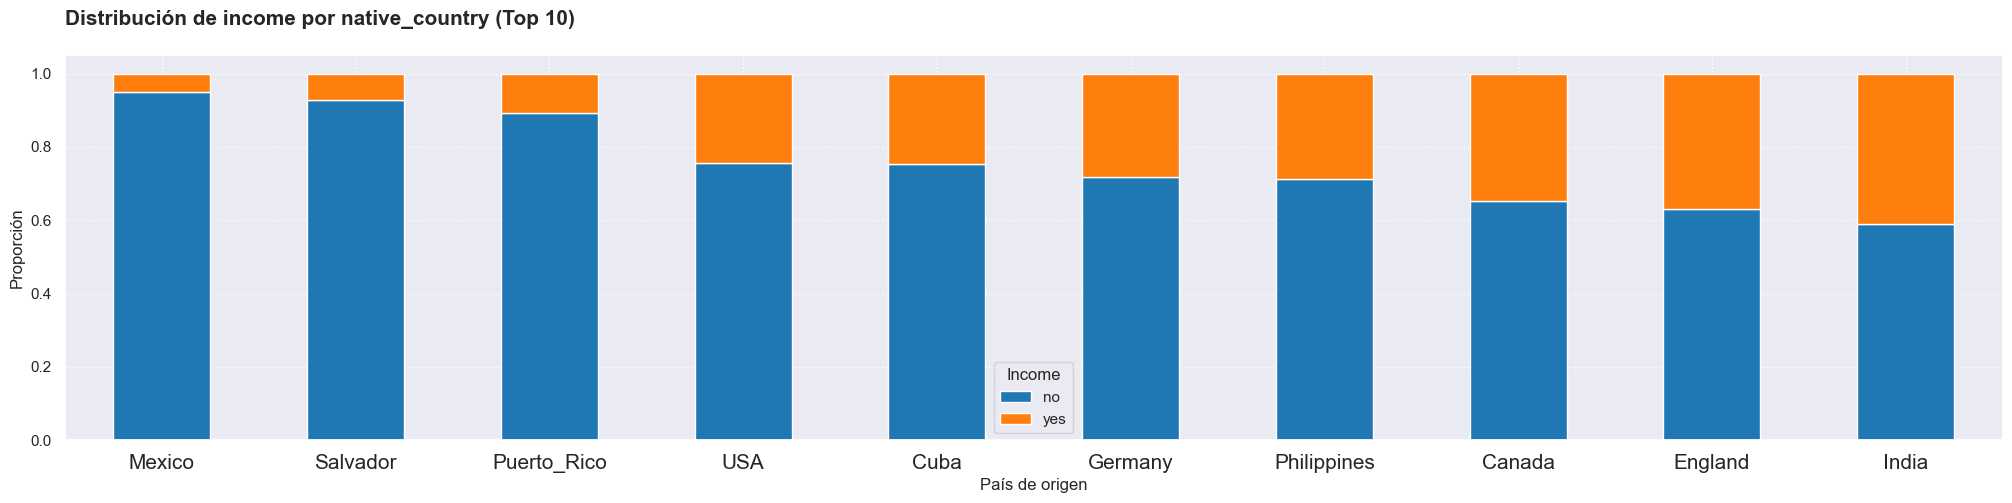

In [8]:
# native country

# top 10 para hacer el análisis más legible
top_countries = df_clean['native_country'].value_counts(dropna= False).head(10).index
df_top_native = df_clean[df_clean['native_country'].isin(top_countries)]

# tabla cruzada de native-country vs income
# cuántas filas hay por para cada categoría (y separadas por income)
country_income_counts = pd.crosstab(df_top_native['native_country'],
                                    df_top_native['income'])

# conversión: de conteos a proporciones por fila (distribución porcentual)
country_income_prop = (country_income_counts
                       .apply(lambda x: x / x.sum(), axis=1)
                       .sort_values(by= 'yes', ascending= True))

country_income_prop.plot(kind='bar', stacked=True,figsize= (25,5) ) # stacked
plt.title("Distribución de income por native_country (Top 10)\n", 
          fontsize= 15, weight= 'bold', loc= 'left')
plt.xlabel("País de origen"), plt.ylabel("Proporción")
plt.legend(title='Income'), plt.xticks(rotation= 0, fontsize= 15)
plt.show()

In [9]:
pd.DataFrame(df_clean['native_country'].value_counts()[:10])

,count
native_country,
USA,44666
Mexico,947
Philippines,295
Germany,206
Puerto_Rico,184
Canada,182
Salvador,155
India,151
Cuba,138


## (2.1) análisis de Relaciones no lineales
### columnas numéricas

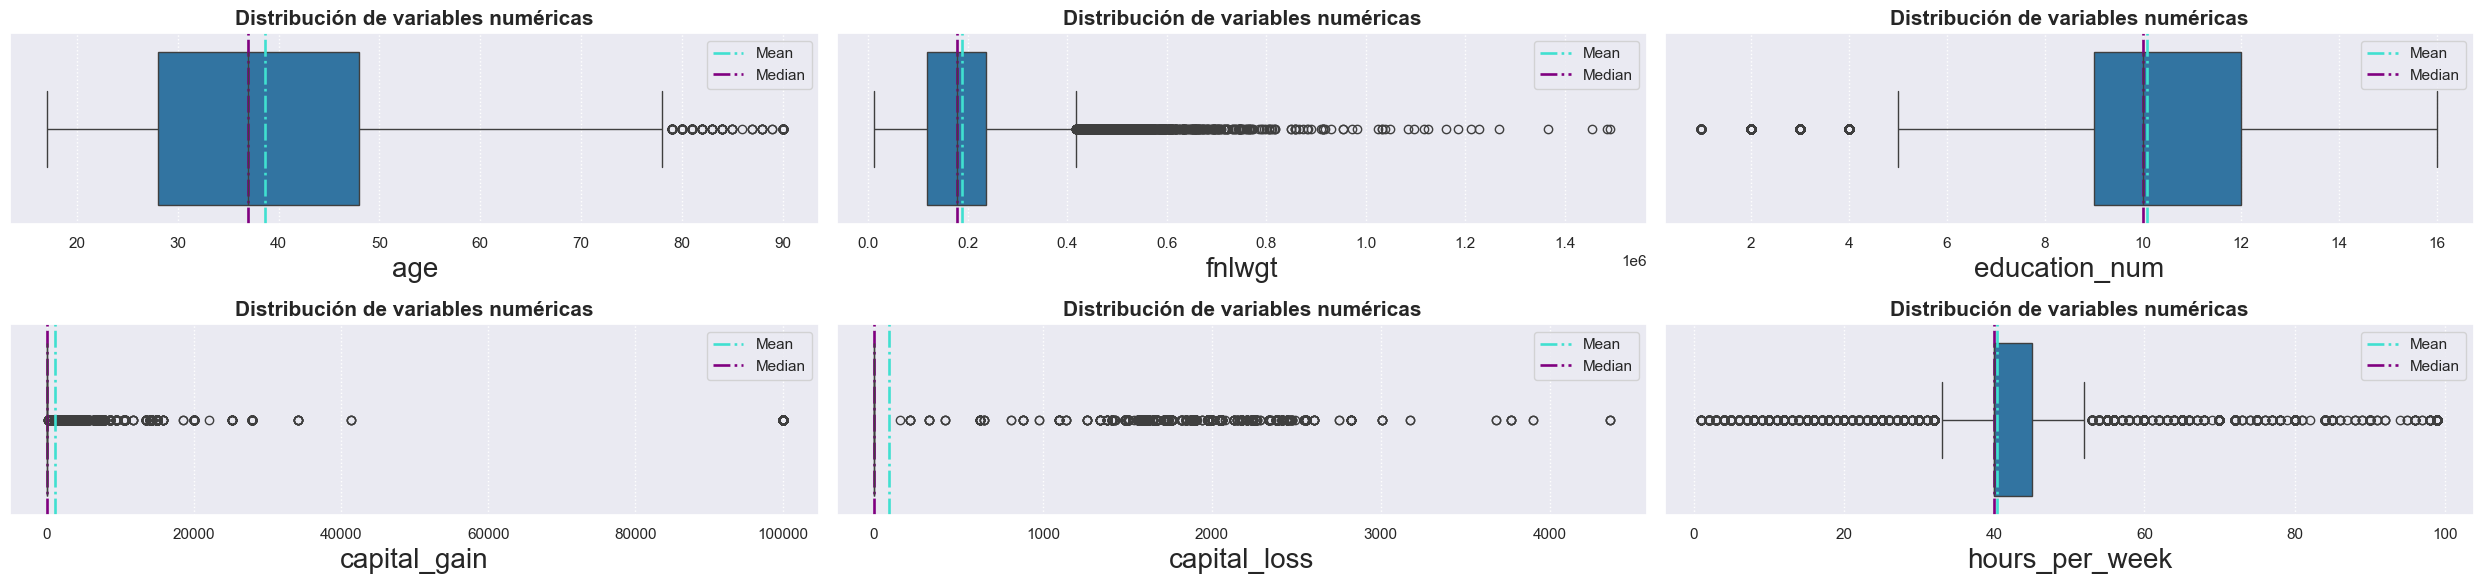

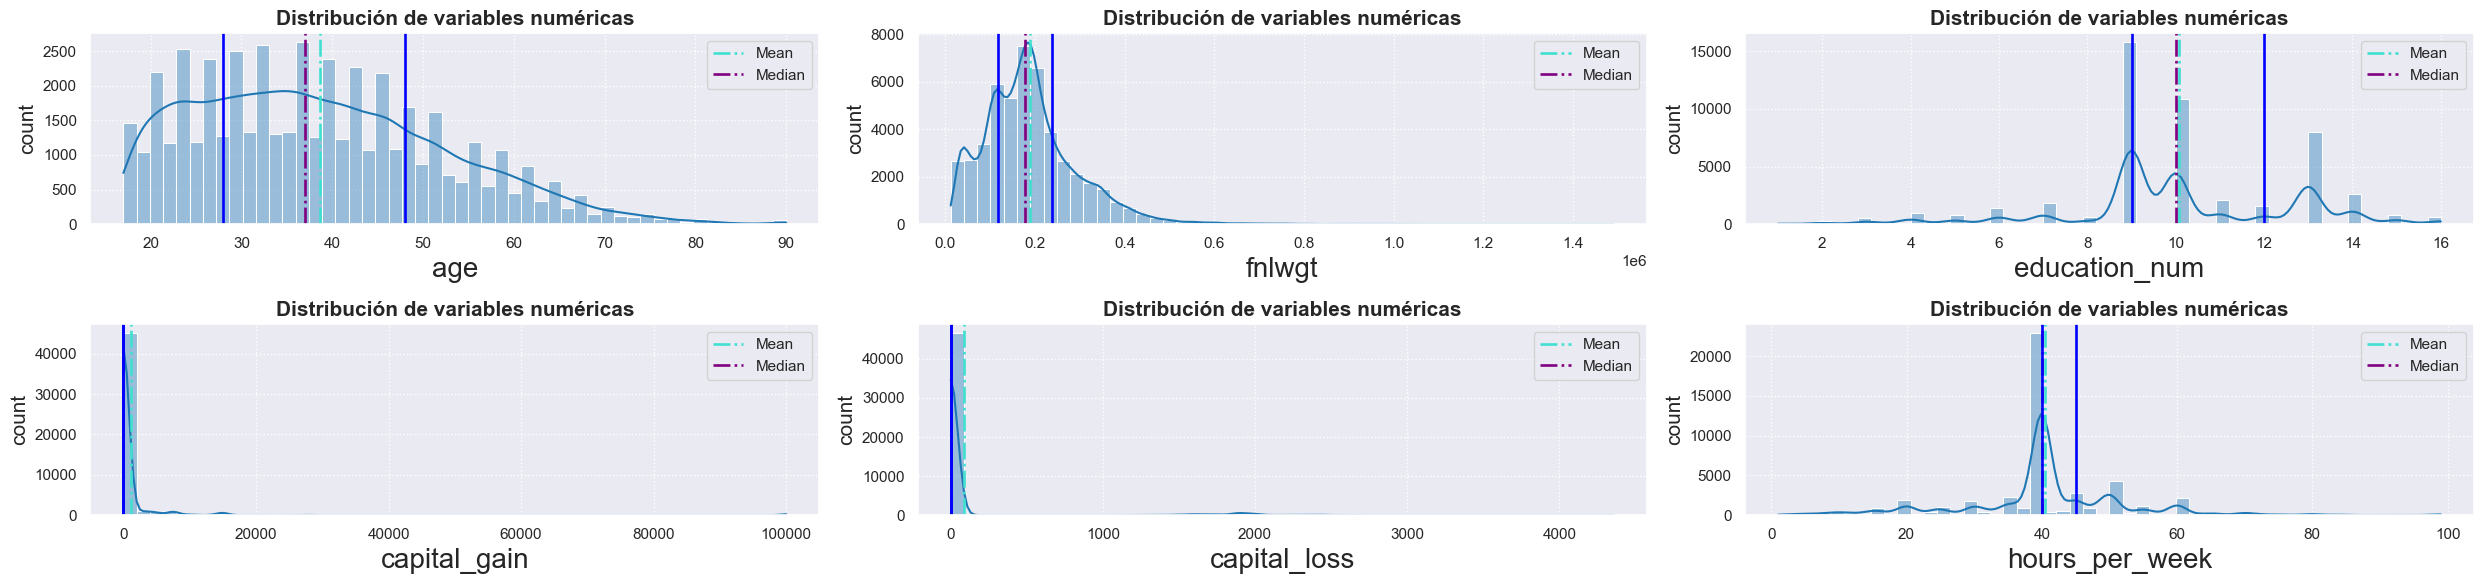

In [10]:
# plot de numéricas (histograma y boxplot)
num_cols = df_clean.select_dtypes(include= ['int', 'float']).columns.tolist()

for i in ['boxplot', 'histplot']:
    cat_plots.plot_dist(df= df_clean, cols= num_cols,
                        subplot_list= [2,3],
                        plot_selection= i,
                        stats= True,
                        title= f'Distribución de variables numéricas')

<div class="alert alert-info">
    <b style="font-size: 1.5em;">🔍 cols numéricas</i></b>
    <ul>
        <li><b>age</b>: distribución platicúrtica con medio sesgo positivo <i>(sesgada a la izquierda)</i>, con la mayoría de los valores en el rango = <b>20,60</b></li>
        <li><b>fnlwgt</b>: distribución leptocúrtica con alto sesgo positivo <i>(sesgada a la izquierda)</i>, y con valores extremadamente altos. lo cuales actúan como outliers.</li>
        <li><b>hours_per_week</b>: leptocúrica simétrica con leve sesgo a la izquierda<i>(el pico de la leptocúrtica se presenta en las 40hs, valor más común)</i>.</li>
        <li><b>education_num</b>: simétrica leptocúrtica que muestra un patron discreto, indicando diferentes los niveles educativos. Siendo tres las más columnes.</li>
    </ul>
    <p>
        <i>se detectan outliers y sesgos que se deberían considerar</i>
    </p>
</div>



Se entrenará Random Forest para analizar la importancia de las variables numéricas en la predicción de `income`

In [11]:
#num_cols = df_clean.select_dtypes(include= ['int', 'float']).columns.tolist()

# dividimos y hacemos el split
X_num = df_clean[num_cols]
y     = df_clean['income']

X_train, X_test, y_train, y_test = tts(X_num, y , test_size= 0.2, random_state= 42)

# modelo
random_forest_model = RandomForestClassifier(n_estimators= 100, random_state= 42)
random_forest_model.fit(X_train, y_train)

# desempeño
y_pred = random_forest_model.predict(X_test)

# feature importance
importance = pd.DataFrame({'column': num_cols,
                           'importance': random_forest_model.feature_importances_})

importance = importance.sort_values(by= 'importance', ascending= False)

In [12]:
importance

,column,importance
1,fnlwgt,0.401074
0,age,0.194736
3,capital_gain,0.137769
2,education_num,0.114302
5,hours_per_week,0.098728
4,capital_loss,0.053392


In [13]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          no       0.85      0.90      0.87      7375
         yes       0.62      0.51      0.56      2388

    accuracy                           0.80      9763
   macro avg       0.74      0.71      0.72      9763
weighted avg       0.79      0.80      0.80      9763



<div class="alert alert-info">
    <b style="font-size: 1.5em;">🔍 importances</i></b>
    <ul>
        <li><b>fnlwgt</b>: <b>40.10%</b> Esta variable tiene la mayor importancia y sugiere una alta correlación con la predicción</li>
        <li><b>age</b>: <b>19.47%</b> Es razonable <i>(dado el contexto de análisis)</i> que la edad tenga una importancia significativa porque suele estar relacionada con el tipo de empleo / ingresos.</li>
        <li><b>capital_gain / loss</b>: Aportan algo de información</li>
        <li><b>education_num</b>: Aunque menos que las anteriores, su aporte es relevante, lo cuál es lógico considerando la relación entre educación e ingresos</li>
        <li><b>hours_per_week</b>: <b>~10%</b>menos peso de lo esperado</li>
    </ul>
    <p>
        <i>se detectan outliers y sesgos que se deberían considerar</i>
    </p>
</div>
<div class="alert alert-info">
    <b style="font-size: 1.5em;">🔍 clasification report (desmpeño del modelo)</i></b>
    <ul>
        <li><b>Accuracy</b>: <b>80 %</b> Aceptable</li>
        <li><b>Recall</b>:
            <code>income = yes</code><b>(51 %) Esta es la clase moniritaria</b> Es más bajo que <code>no</code> <b>(90 %)</b> Refuerza el desbalance en target (income) observado durante diferentes etapas de este análisis.</li>
        <li><b>Precision</b>: yes  <b>62 %</b>
    </ul>
</div>
<div class="alert alert-success">
    <b style="font-size: 1.5em;">confirmación de relación no lineal: numéricas vs target</i></b>
    <p>El resultado sugiere la existencia de relaciones no lineales entre las numéricas</p>
    <ul>
        <li><b>patrones detectados</b>: <i>(no esperados)</i> 
        <p><code>capital_gain</code> / <code>loss</code>. Aunque tienen observaciones cercanas a <b>0</b> los valores extremos podrían influir significativamente en <code>income</code></li></p>
        <p><code>fnlwgt</code>: Tiene una gran importancia <b>(40.10 %)</b>. El % relativamente alto confirma patrones complejos entre esta variable e ingresos altos (<code>income = yes</code>) </p>
        <li>importancia de las variables: <code>fnlwgt, age, capital_gain</code> afectan a <b>income</b> de formas que no son estrictamente lineales</li>
    </ul>
    
</div>

### Relación no lineal en categóricas

Basándonos en el análisis previo *(notebook 01)* usaremos a `occupation` y `worcklass` como las columnas categóricas más relevantes

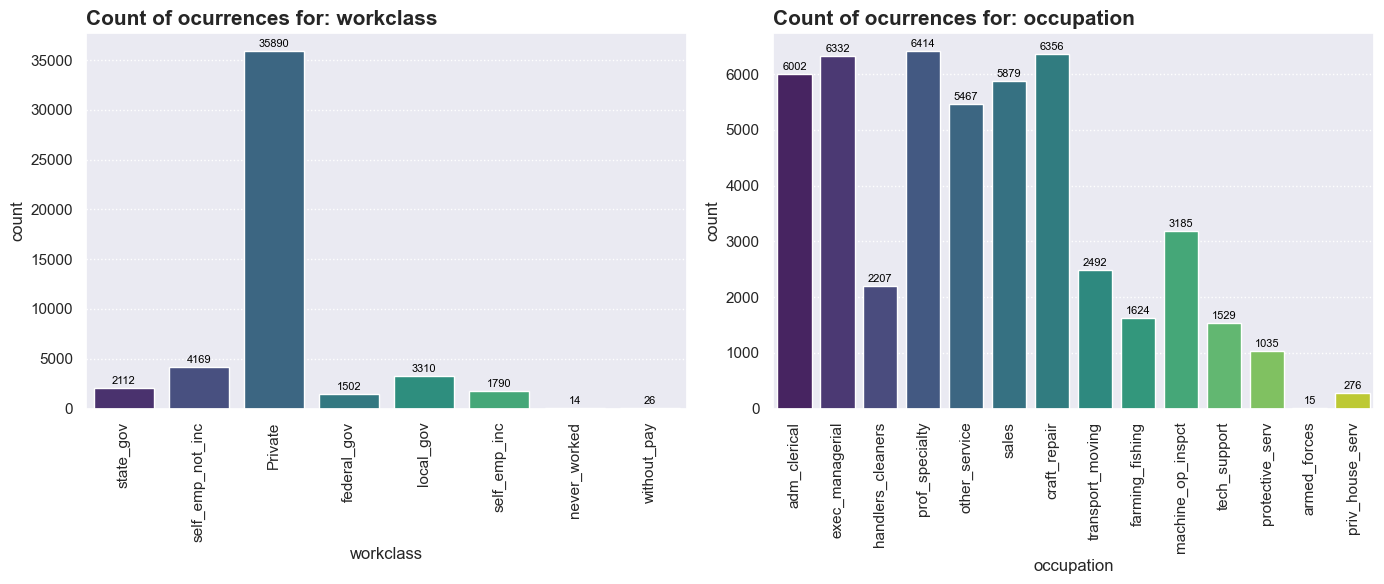

In [14]:
cat_cols = ['workclass', 'occupation']
cat_plots.plot_cat_feq(df= df_clean, cols= cat_cols, rotation= 90, bar_nums= True)

Graficaremos una tabla cruzada para analizar la variable objetivo y las categóricas
* `income` vs `workclass, occupation`

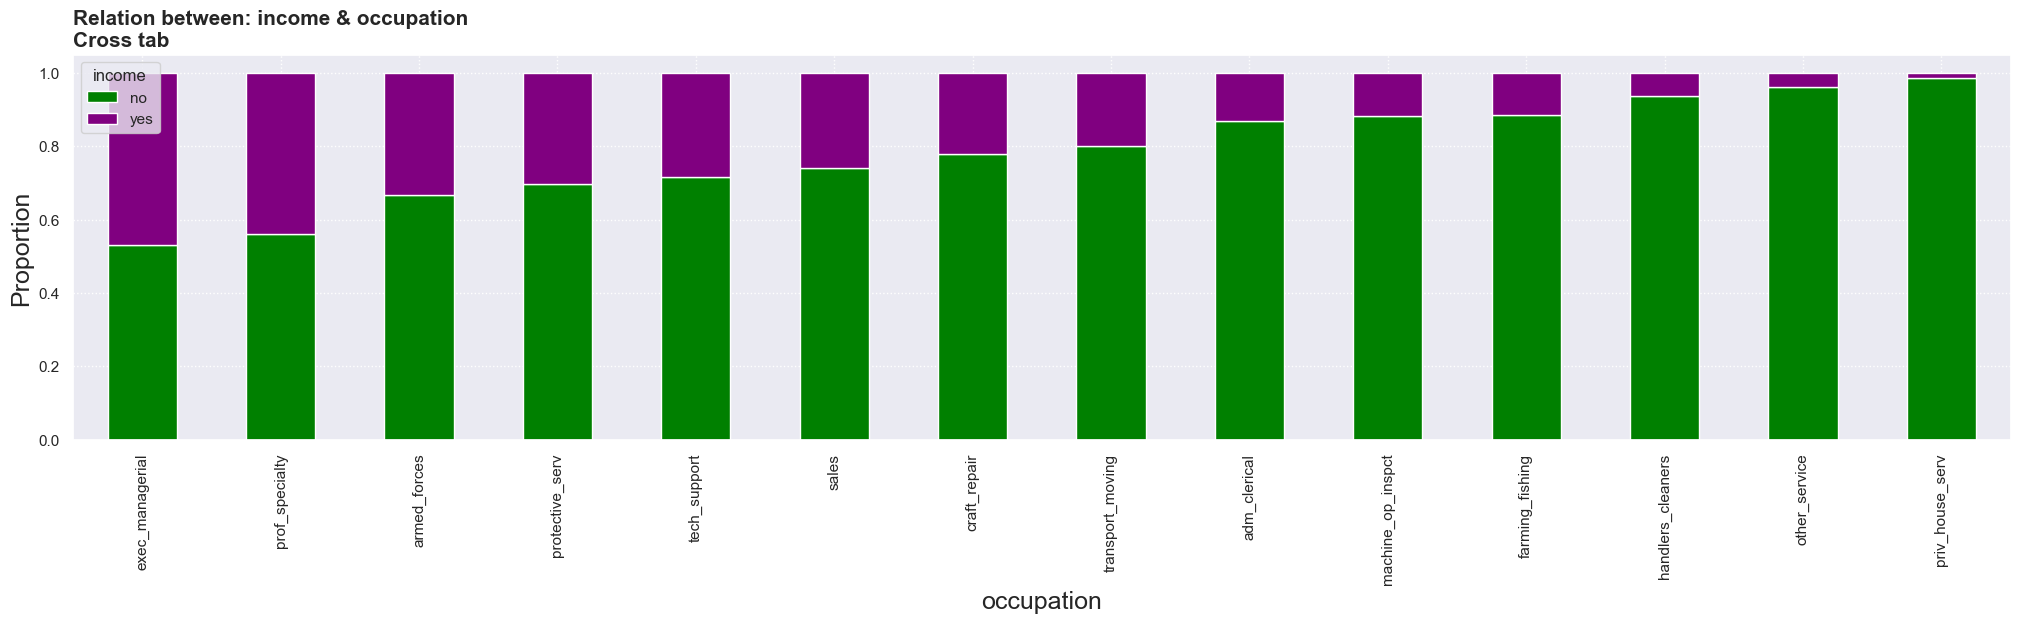

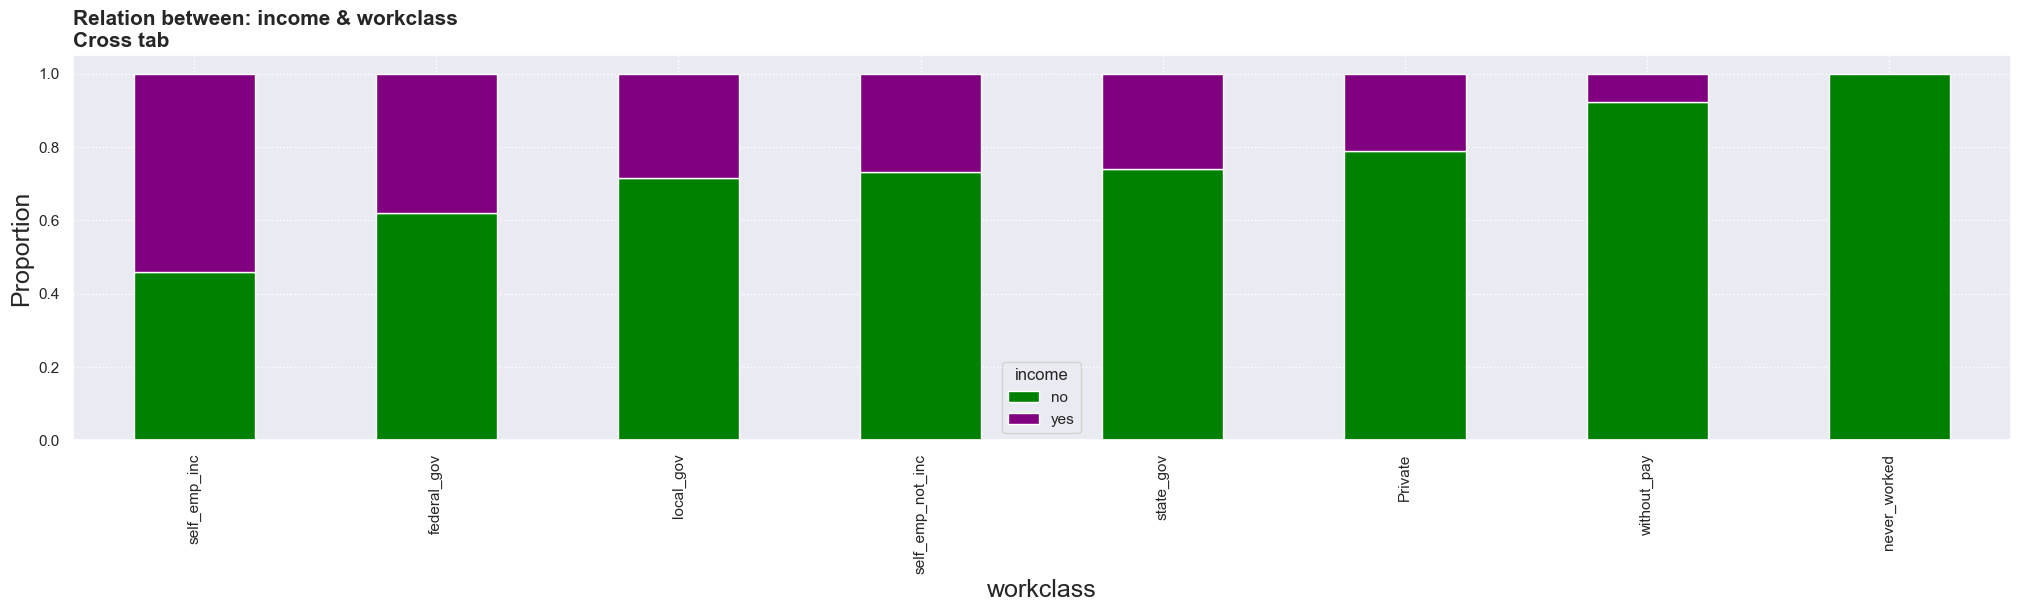

In [15]:
# relación target vs catgóricas
def create_cross_tab(df, cols: List[str], target_col:str, plot: bool= False)-> List[pd.DataFrame]:
    dfs = []
    for col in cols:
        cross_tab = pd.crosstab(df[col], df[target_col], normalize= 'index')
        cross_tab = cross_tab.sort_values(by= 'yes', ascending= False)
        df_crosstab = pd.DataFrame(cross_tab)
        dfs.append(df_crosstab)
    
    if plot:
        for i in dfs:
            col = i.index.name
            i.plot(kind='bar', stacked=True, figsize= (25,5), color= ['green', 'purple'])
            plt.title(f'Relation between: {target_col} & {col}\nCross tab ',
                      fontsize= 15, weight= 'bold', loc= 'left')
            plt.xlabel(col, fontsize= 18), plt.ylabel('Proportion', fontsize= 18)
    return dfs

cross_occupation, cross_workclass = create_cross_tab(df= df_clean,
                                                     cols= ['occupation', 'workclass'],
                                                     target_col='income',
                                                     plot= True)

In [16]:
cross_occupation

income,no,yes
occupation,,
exec_managerial,0.529690,0.470310
prof_specialty,0.559557,0.440443
armed_forces,0.666667,0.333333
protective_serv,0.696618,0.303382
tech_support,0.716154,0.283846
sales,0.741623,0.258377
craft_repair,0.778949,0.221051
transport_moving,0.801364,0.198636
adm_clerical,0.867711,0.132289


In [17]:
cross_workclass

income,no,yes
workclass,,
self_emp_inc,0.458659,0.541341
federal_gov,0.619840,0.380160
local_gov,0.715408,0.284592
self_emp_not_inc,0.731111,0.268889
state_gov,0.741004,0.258996
Private,0.790109,0.209891
without_pay,0.923077,0.076923
never_worked,1.000000,0.000000


## (2.2) Datos desbalanceados en income
A continuación se presentarán diferentes estrategias para resolver el problema, luego se elegirá una de ellas.

<div class="alert alert-info">
    <b style="font-size: 1.5em;">📚 sumario</i></b>
    <ul>
        <li><b>shape (total)</b>: (48813,15) </li>
        <li><b>proporciones</b>: <code>income= yes</code>: <b>~76%</b>, <code>income= no</code>: <b>~23%</b></li>
        <li><b>conteo <code>income</code></b>: <i>yes</i>: 37128, <i>no</i>: 11685</li>
    </ul>
</div>

**(1) balanceo por subsets:** Dada la enorme diferencia entre las ocurrencias de *yes* y *no* en nuestra variable objetivo `income` nos trae dos problemas:
* si hacemos oversampling de *yes*, el dataset tendría demaciados datos inventados, aumentando la posibilidad de sesgo
* si hacemos undersampling de *no*, estaríamos perdiendo datos que podrían ser importantes, dado que una gran propoción del dataset $>70$% está en esta categoría

**(2) oversampling:** Es la técnica más común. Balanceamos el dataset creando más ocurrencias a *yes*, conservando la información de *no*
* podría añadir ruido

**(3) BalancedRandomForestClassifier:**
`RandomForest` diseñado para trabajar directamente con datos desbalanceados. Aplica undersampling a cada muestra, de esta forma se estará entrenando con elementos balanceados
* preserva información en ambas clases



### método 1: balanceo de datos por oversampling (SMOTE)

In [18]:
# separación de vars categóricas y numéricas
cat_cols = df_clean.select_dtypes(include= ['object', 'category']).columns
num_cols = df_clean.select_dtypes(include= ['int', 'float']).columns

# X's entrenamiento, y target
X_sm = df_clean.drop(columns= 'income')  
y_sm = df_clean['income']              

#- OHE -#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#
encoder_sm = OHE(sparse_output= False, handle_unknown= 'ignore')

# encoding a categóricas
cat_cols      = [col for col in cat_cols if col != 'income'] #----------- excluimos a la variable target
X_cat_encoded_sm = encoder_sm.fit_transform(X_sm[cat_cols])

# df encoded
encoded_cols_names  = encoder_sm.get_feature_names_out(cat_cols)

X_cat_encoded_sm = pd.DataFrame(X_cat_encoded_sm,
                                columns= encoded_cols_names,
                                index= X_sm.index)

X_encoded_smote = pd.concat([X_sm[num_cols], X_cat_encoded_sm], axis= 1) #----- numéricas categóricas ya codificadas

Shape del dataset balanceado: (74256, 15)
Distribución de 'income':
income
no     37128
yes    37128
Name: count, dtype: int64


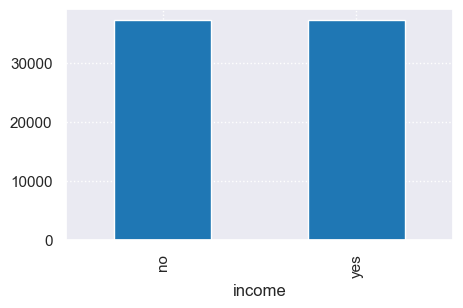

In [19]:
#- balanceo con smote -#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#
smote_model  = SMOTE(random_state= 42)
X_res_sm, y_res_sm = smote_model.fit_resample(X_encoded_smote, y)

# Verificamos
y_res_sm.value_counts().plot(kind= 'bar', figsize= (5, 3))

#- df balanceado -#-#-#–#–#-#-#–#-#-#-#-#–#–#-#-#–#-#-#-#-#–#–#-#
X_res_num_sm         = X_res_sm[num_cols]  
X_res_cat_encoded_sm = X_res_sm.drop(columns= num_cols) #--------------------- categóricas codificadas
X_res_cat_decoded_sm = encoder_sm.inverse_transform(X_res_cat_encoded_sm) # variables a estado original

X_res_cat_decoded_sm = pd.DataFrame(X_res_cat_decoded_sm,
                                 columns= cat_cols,
                                 index= X_res_sm.index) #------------------ X's

X_res_final = pd.concat([X_res_num_sm, X_res_cat_decoded_sm], axis= 1) #------ X's + y's

# Agregamos target al df balanceado
df_balanced_smote = X_res_final.copy()
df_balanced_smote['income'] = y_res_sm

# resultados
print(f"Shape del dataset balanceado: {df_balanced_smote.shape}")
print(f"Distribución de 'income':\n{df_balanced_smote['income'].value_counts()}")

#### Análisis de ruido agregado en `income = yes`

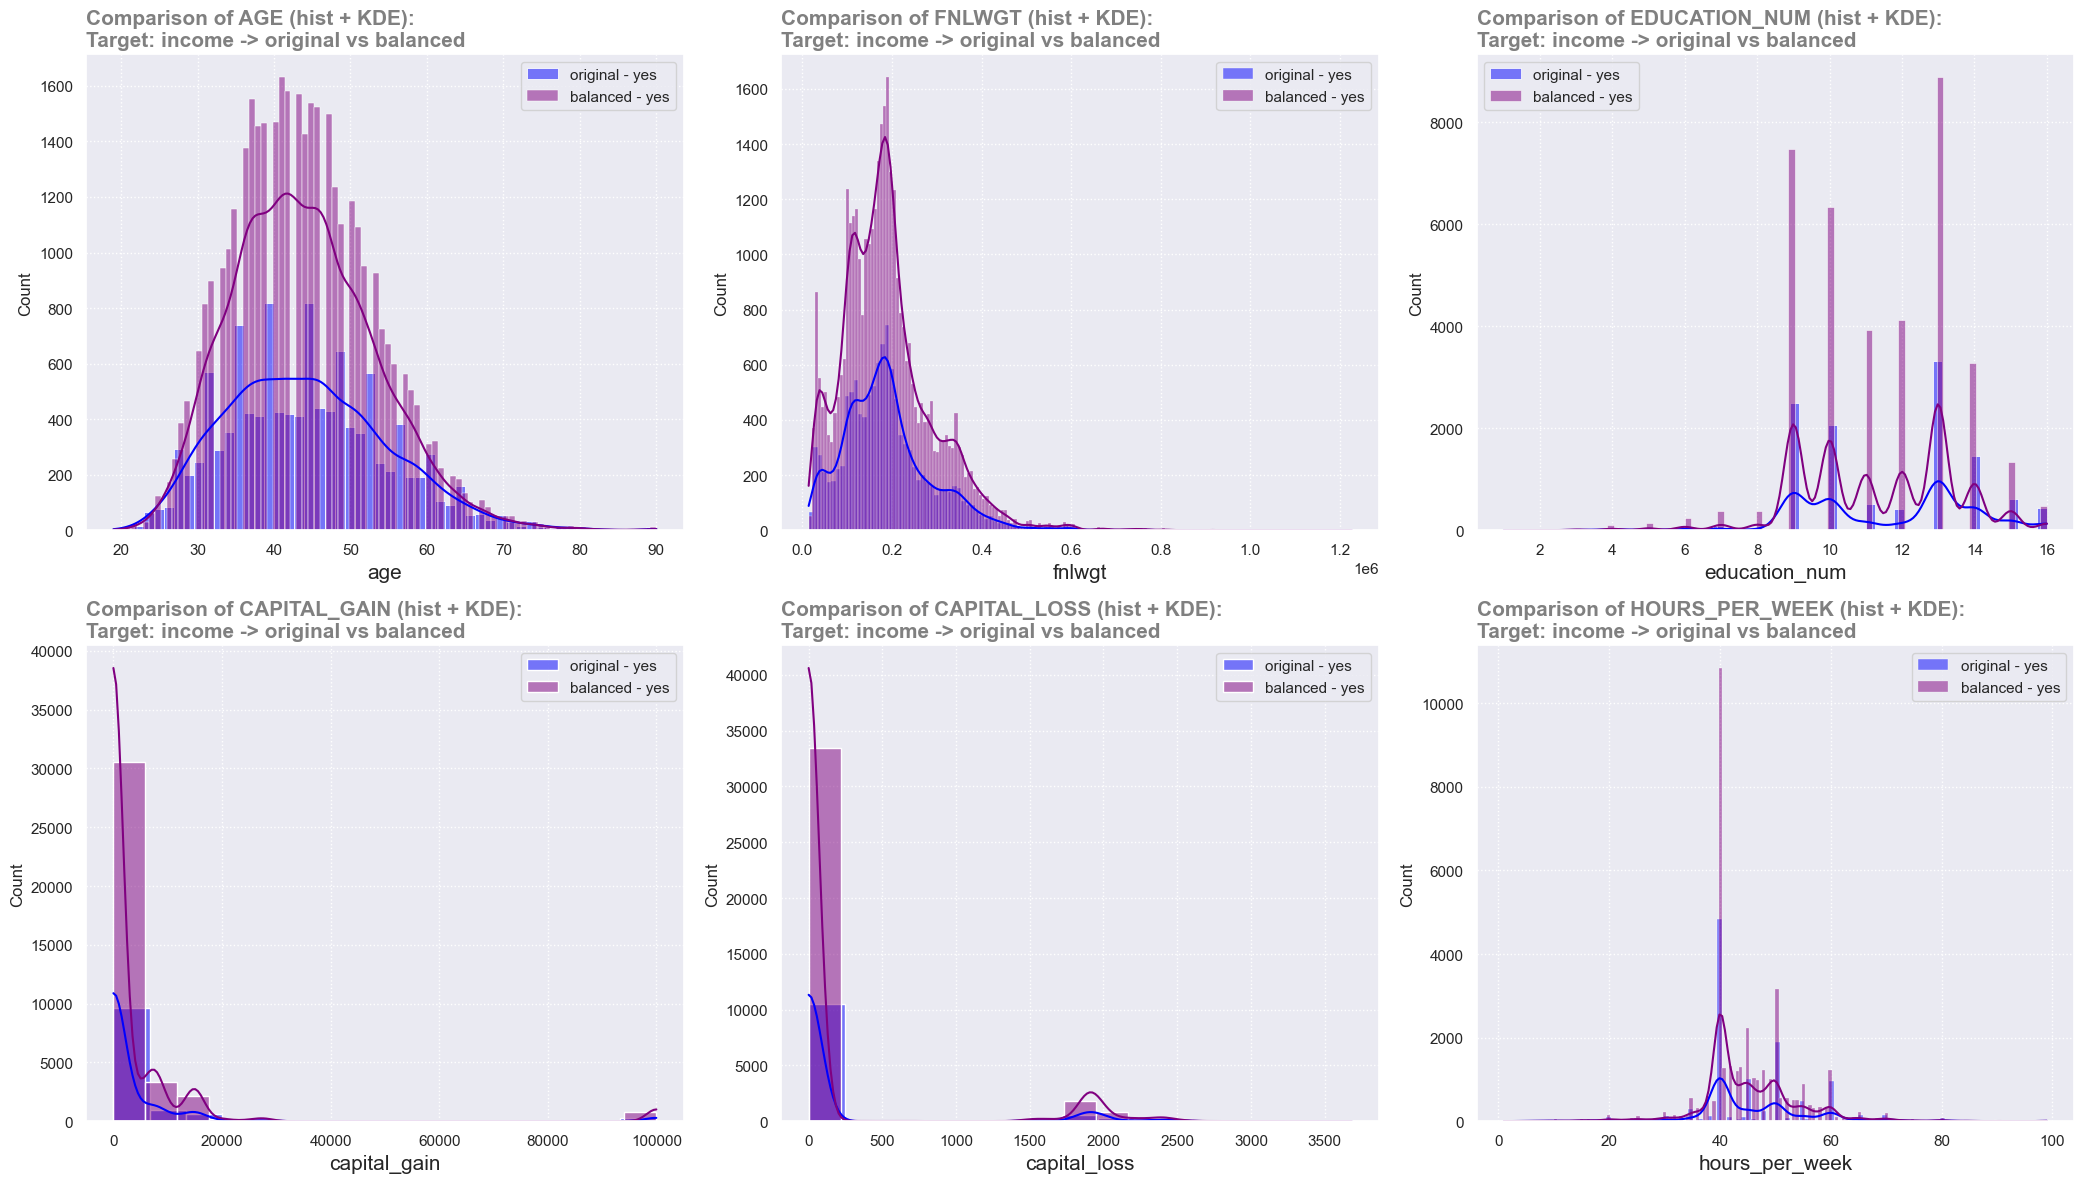

In [20]:
# Análisis de ruido: desbalanceado y balanceado
#num_cols = df_balanced_smote.select_dtypes(include= ['int', 'float']).columns

num_plots.compare_two_dfs_hist(df_1= df_clean, df_2= df_balanced_smote,
                               cols= num_cols, target='income',
                               target_value='yes', df_names= ['original', 'balanced'],
                               colors = ['blue', 'purple'])

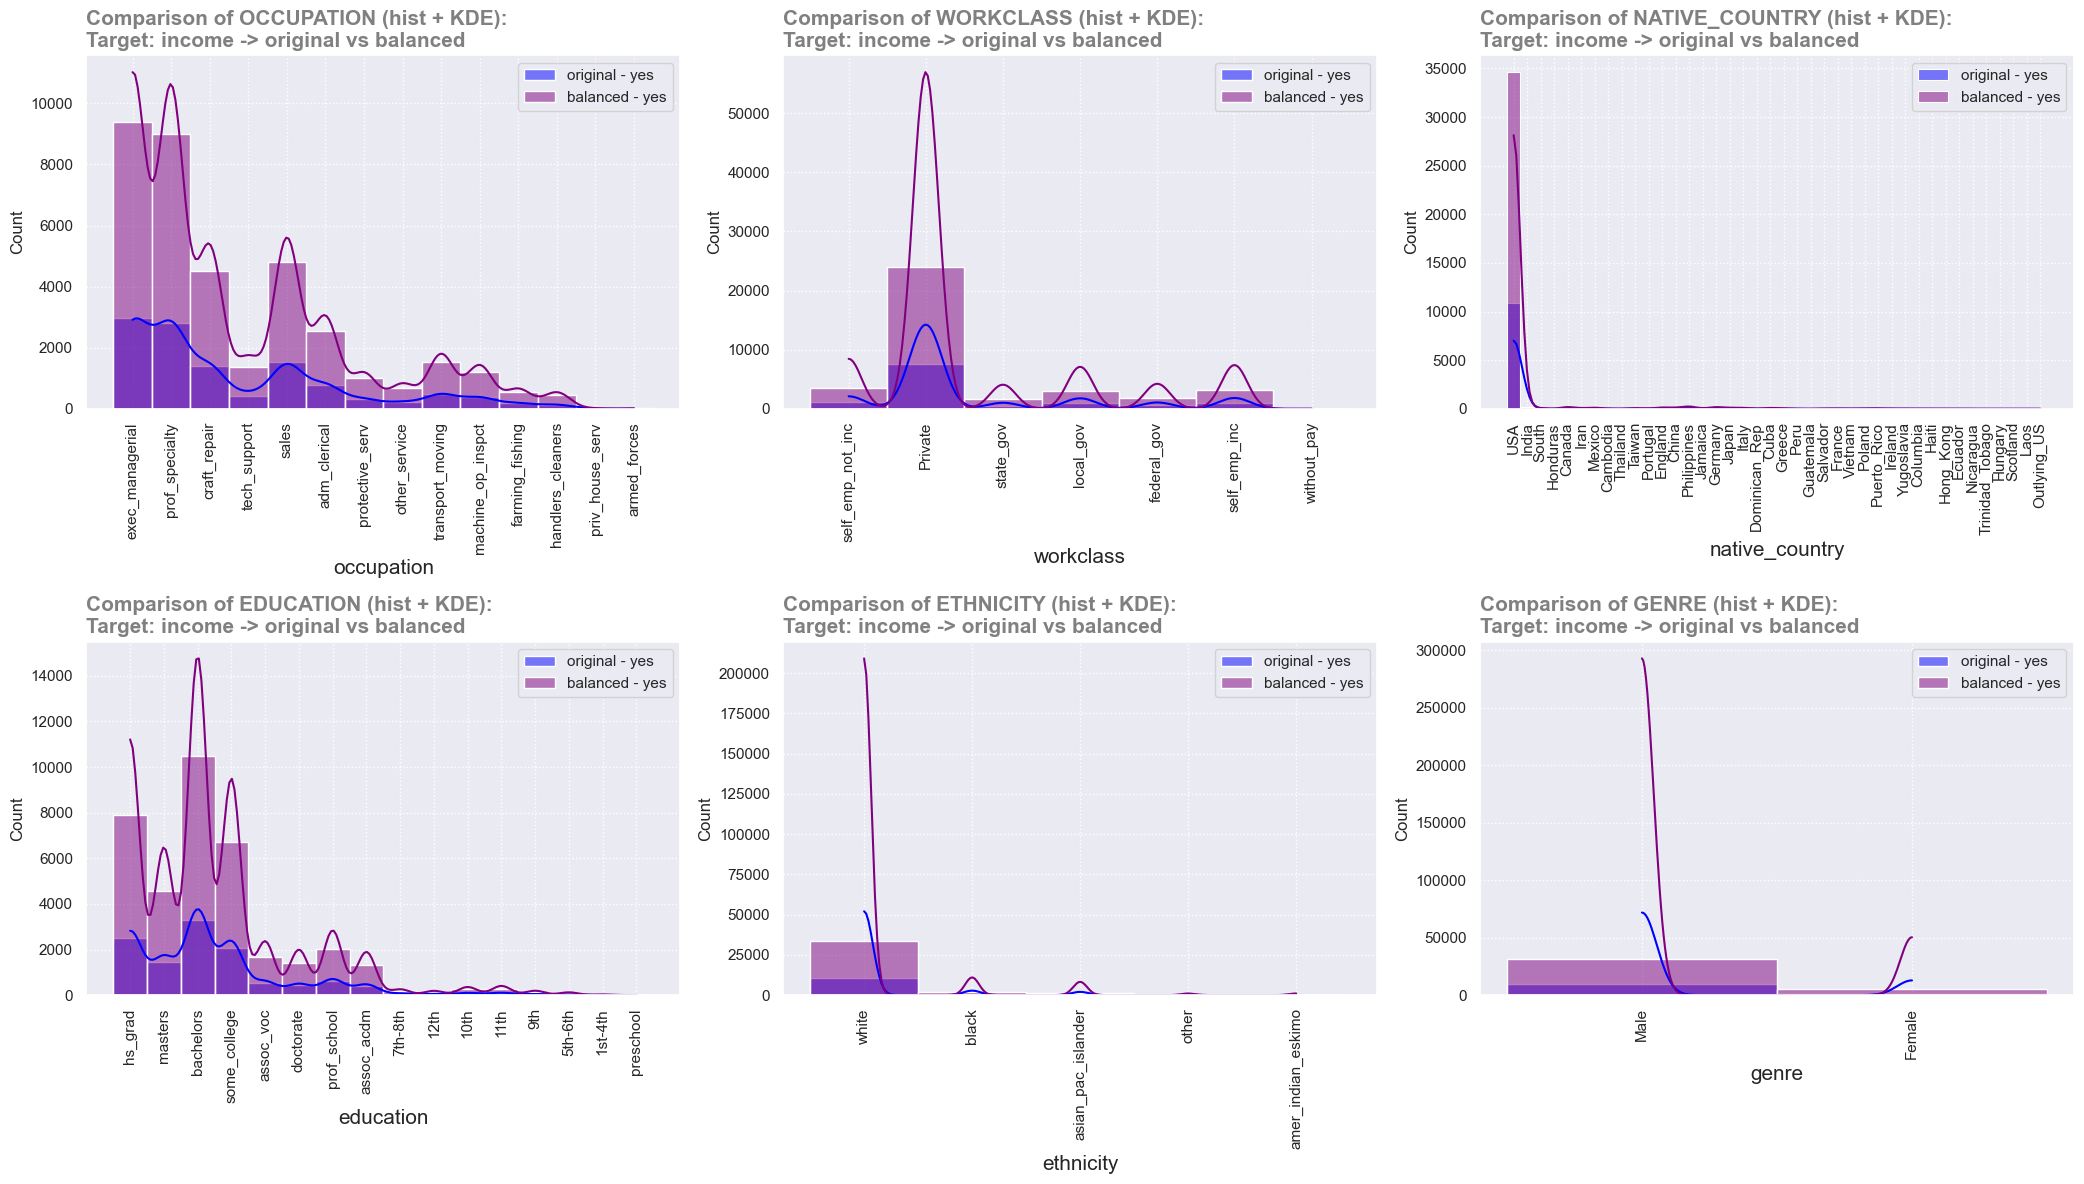

In [21]:
cat_cols_plot = ['occupation', 'workclass', 'native_country', 'education','ethnicity', 'genre']

num_plots.compare_two_dfs_hist(df_1= df_clean, df_2= df_balanced_smote,
                               cols= cat_cols_plot, target='income',
                               target_value='yes', df_names= ['original', 'balanced'],
                               rotation= 90, colors = ['blue', 'purple'])

### método 2: balanceo por subsets
descripción de estrategia

<div class="alert alert-info">
    <b style="font-size: 1.5em;">📚 configuración del tamaño (para el dataset final balanceado)</i></b>
    <p>Se aplicarán direfents configuraciones <i>(tamaños finales del dataset)</i> para encontrar un punto de equilibrio entre el oversampling y undersampling, variando el <i>size</i> final del df balanceado. El objetivo de esto es mejorar la métrica de <b>F1-score</b> por medio de la función <code>find_best_size</code></p>
    <b style="font-size: 1.5em;">🔍 Rol del F1-score en el experimento (para encontrar el <i>size</i> ideal):</i></b>
    <p>combina la precisión <i>(qué tan exactos son los aciertos respecto a los positivos detectados)</i> con el Recall (qué tan bien se detectan los TP)</p>
    <ul>
        <li>util para contextos desbalanceados porque evita que el modelo se "haga el listo" prediciendo la clase mayoritaria y obtenga una presición / exactitud infladas</li>
        <li>en nuestro contexto, el f1-score es una guía que indica qué tan bien el modelo está equilibrando la capacidad de identificar los (TP yes) frente a equivocarse (FP yes)</li>
        <li>el objetivo <b>no es maximizar el F1</b> en si, más bien encontrar una configuración tal que el muestreo mejore la capacidad de predecir la minoritaria, sin sacrificar tanto la mayoritaria. Aquí, nos es más util que accuracy</li>
    </ul>
</div>


In [22]:
#path: ./modules/module_imbalanced.py (func 4)
final_sizes_list= [40000, 51980, 60000, 74256, 80000] # 74256 -> size del SMOTE
imb_methods.find_best_size(df= df_clean, target_col= 'income',
                           final_sizes_list= final_sizes_list)

Distribución original en entrenamiento:
No: 25990, Yes: 8179
Final size: 40000, F1-score (CV): 0.8547
Final size: 51980, F1-score (CV): 0.8671
Final size: 60000, F1-score (CV): 0.8719
Final size: 74256, F1-score (CV): 0.8590
Final size: 80000, F1-score (CV): 0.8406

Mejor configuración encontrada:
Tamaño final: 60000 con F1-score promedio: 0.8719


<div class="alert alert-info">
    <b style="font-size: 1.5em;">💭 Tamaño elegido (balanceo por subsets):</b>
    <p><b>60K</b> muestras totales <i>(30k yes / no)</i>, con un F1-score promedio de <b>~0.8719</b></p>
    <ul>
        <li> Al aumentar el tamaño final del dataset final, parece que el F1-score mejora</li>
        <li>Esto sugiere que perder menos datos de la clase mayoritaria (no submuestrear) y generar sintéticos podría estar dando un modelo más robusto</li>
        <li><i>pero entre más grande, mayor costo computacional</i></li>
    </ul>
    <p><b>Factores no considerados</b>: Dado que al implementar un <code>tts</code> tomamos un <b>%</b> del dataset para test, dicho porcentaje se estaría extrayendo del total de filas, por tal motivo no se llegaría a las 30k. a la hora de terminar el procedimiento se obtendrían <b>51980</b> y no <b>60k</b></p>
    <ul>
        <li> por tal motivo se ha decidido usar <b>51980</b> filas</li>
    </ul> 
</div>

    



### proceso de balanceo por subsets: *oversampling* + *undersampling*

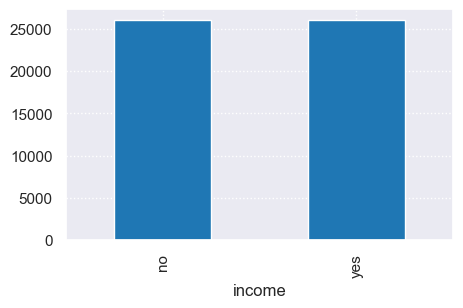

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week,occupation,workclass,native_country,education,marital_status,relationship,ethnicity,genre,income
0,21,255957,10,4101,0,40,exec_managerial,Private,USA,some_college,never_married,not_in_family,white,Female,no
1,46,35969,13,0,0,51,exec_managerial,Private,USA,bachelors,married_civ_spouse,husband,white,Male,no
2,26,196899,12,0,0,40,craft_repair,Private,USA,assoc_acdm,separated,not_in_family,other,Female,no


In [23]:
# this strategy was discarded due the low performance of the method vs the SMOTE
# path: ./modules/discarted_methods.py

df_balanced_subsets['income'].value_counts().plot(kind= 'bar', figsize= (5, 3))
plt.show()
df_balanced_subsets[:3]

#### análisis de ruido (*original* vs *smote* | *subsets*)
evaluaremos ambos datasets balanceados con diferentes estrategias. Teniendo en cuenta:
* ruido agregado por el balanceo
* métricas: F1-score, recall, accuracy, support

In [24]:
X_original = df_clean.drop(columns='income')

X_smote    = df_balanced_smote.drop(columns='income')
X_subsets  = df_balanced_subsets.drop(columns='income')

# análisis de ruido: ./modules/module_imbalanced.py
# (1) codificar categóricas
# (2) encontrar índices de datos sintéticos
# (3) analizar ruido: midiendo distancias (originales vs sintéticos)

print('Cálculo de distancias: originales vs balanceados\nSMOTE:')
distances_smote   = imb_methods.analyze_noise(X_original= X_original, X_balanced= X_smote)

print('Subsets:')
distances_subsets = imb_methods.analyze_noise(X_original= X_original, X_balanced= X_subsets)

Cálculo de distancias: originales vs balanceados
SMOTE:
Distancia promedio entre datos sintéticos y originales: 1.4652
Subsets:
Distancia promedio entre datos sintéticos y originales: 1.5124


In [25]:
num_cols = ['age', 'fnlwgt', 'hours_per_week']
cat_cols = ['occupation', 'relationship', 'education']

Original vs Subsets


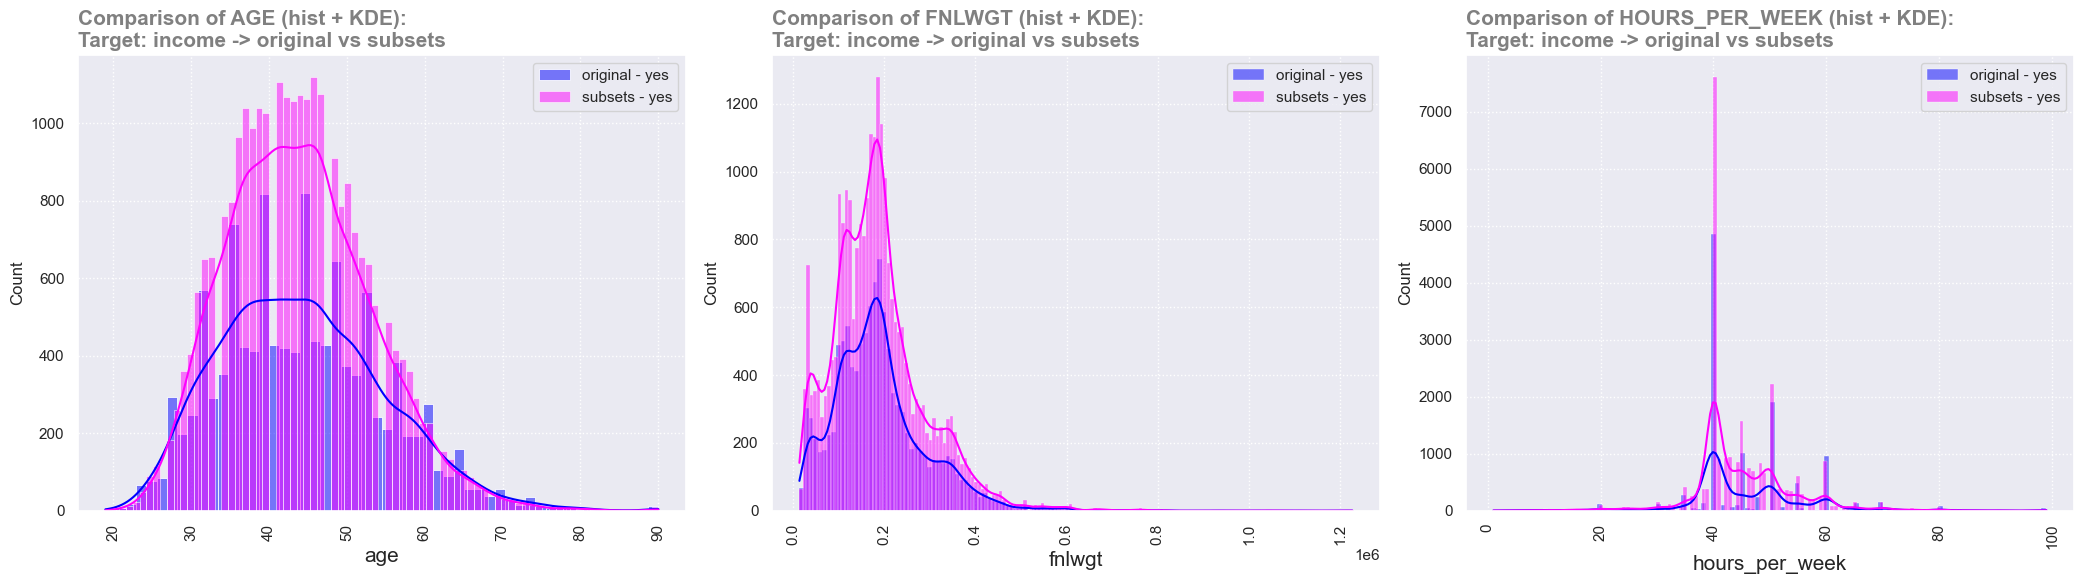

In [26]:
print('Original vs Subsets')
num_plots.compare_two_dfs_hist(df_1= df_clean, df_2= df_balanced_subsets,
                               cols= num_cols, target='income',
                               target_value='yes', df_names= ['original', 'subsets'],
                               rotation= 90, colors = ['blue', 'magenta'])

SMOTE vs Subsets


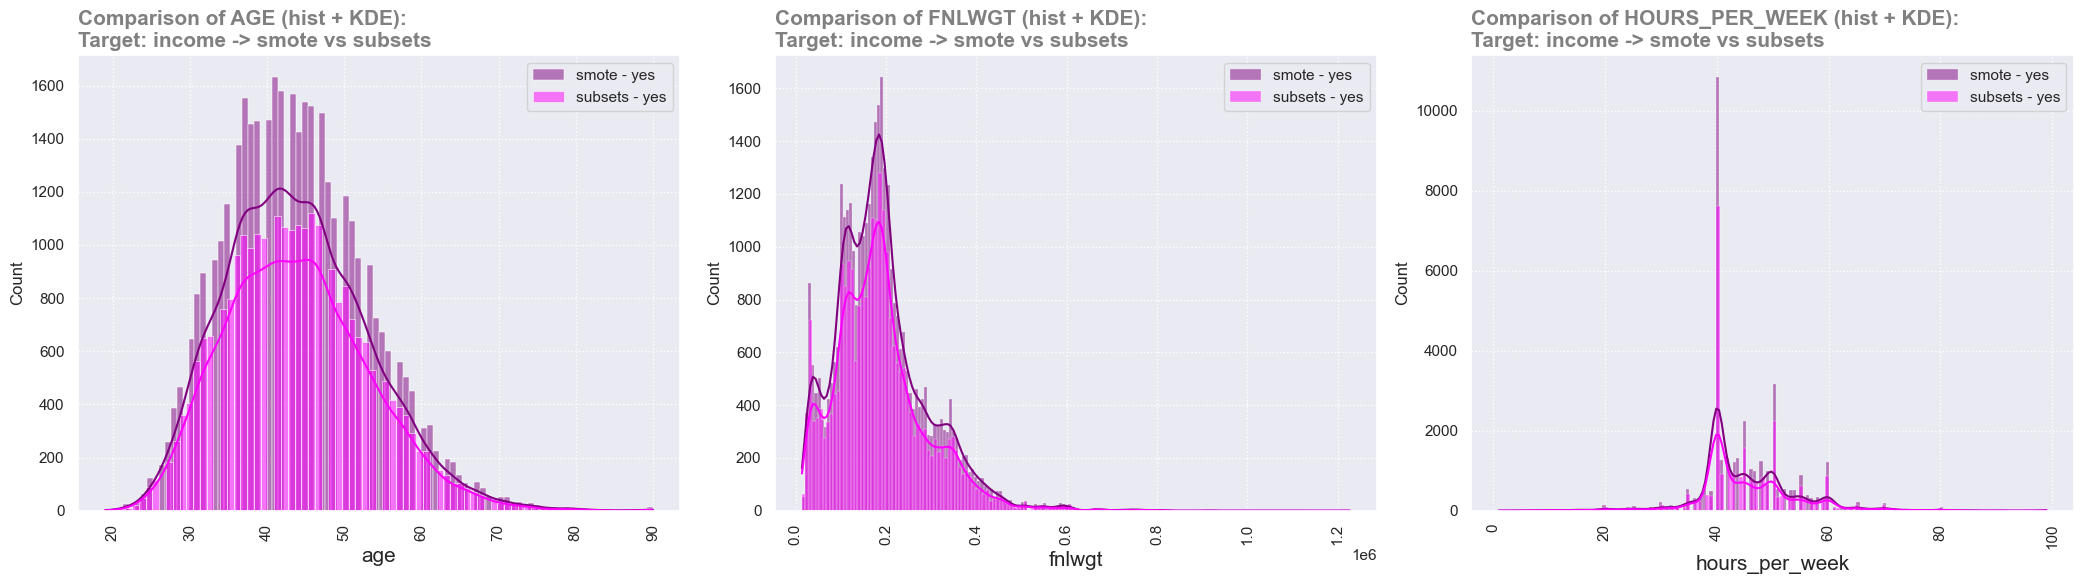

In [27]:
print('SMOTE vs Subsets')
num_plots.compare_two_dfs_hist(df_1= df_balanced_smote, df_2= df_balanced_subsets,
                               cols= num_cols, target='income',
                               target_value='yes', df_names= ['smote', 'subsets'],
                               rotation= 90, colors = ['purple', 'magenta'])

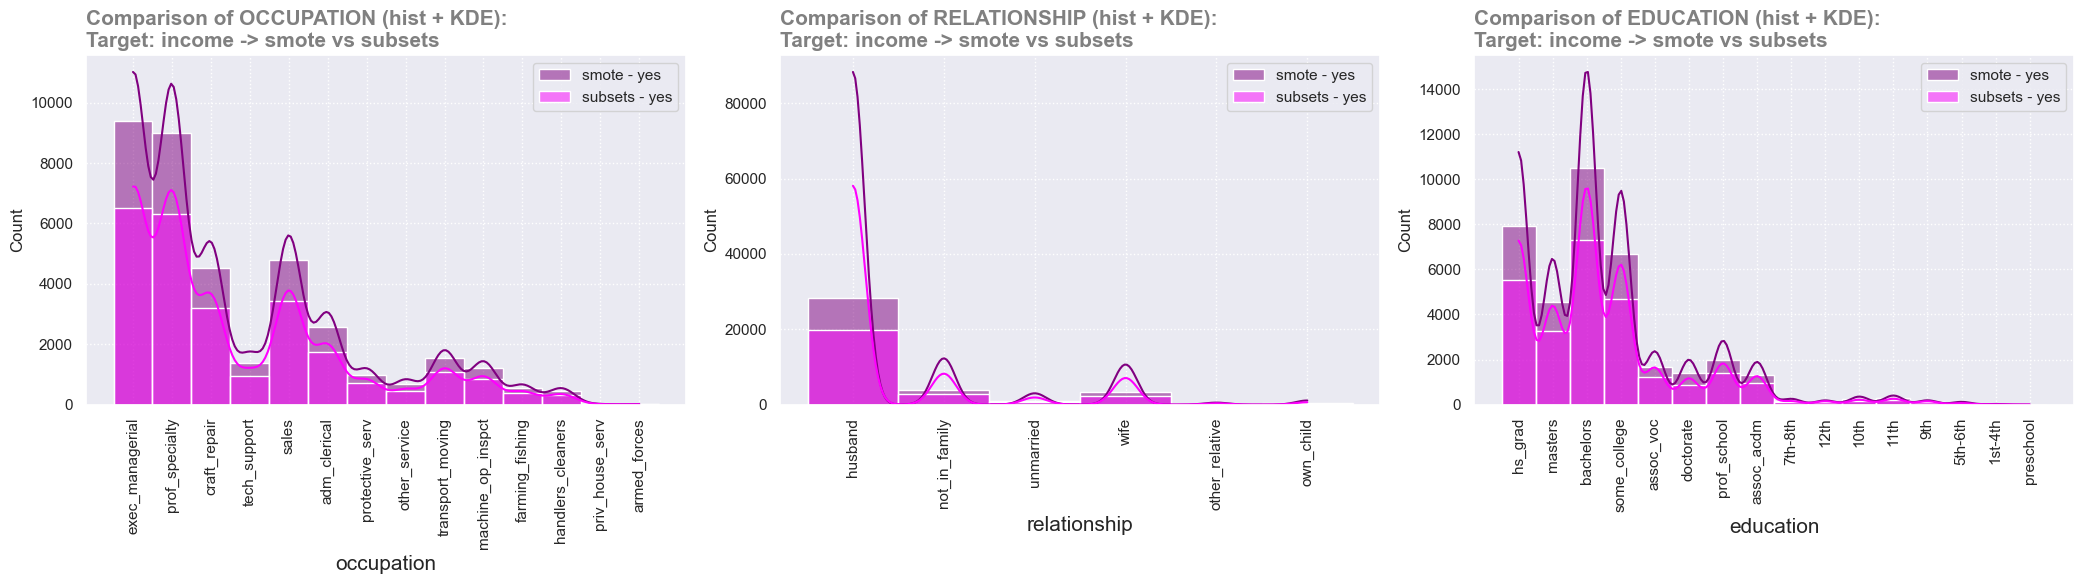

In [28]:
num_plots.compare_two_dfs_hist(df_1= df_balanced_smote, df_2= df_balanced_subsets,
                               cols= cat_cols, target='income',
                               target_value='yes', df_names= ['smote', 'subsets'],
                               rotation= 90, colors = ['purple', 'magenta'])

In [29]:
# balanceo SMOTE
results_smote  = imb_methods.evaluate_balanced_data(df= df_balanced_smote, name_method="smote")

# balanceo Subsets
results_subset = imb_methods.evaluate_balanced_data(df= df_balanced_subsets, name_method="subsets")

# balanceo SMOTE + PCA (evaluación de desempeño al implementar PCA)
# n_components -> 5, 8, 10, 12(desmepeño más alto en PCA)
results_smote_pca = imb_methods.train_model_with_smote_pca(df_balanced_smote, target_col='income',
                                                           n_components=12)

F1-score (CV) con 51980k: 0.8950
F1-score en test: 0.9044
Classification Report (SMOTE):
                     no           yes  accuracy     macro avg  weighted avg
precision      0.922932      0.883052  0.902007      0.902992      0.902993
recall         0.877278      0.926737  0.902007      0.902008      0.902007
f1-score       0.899526      0.904368  0.902007      0.901947      0.901947
support    11139.000000  11138.000000  0.902007  22277.000000  22277.000000

 *-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*- 

F1-score (CV) con 51980k: 0.8963
F1-score en test: 0.9025
Classification Report (SUBSETS):
                    no          yes  accuracy     macro avg  weighted avg
precision     0.919039     0.883133  0.900282      0.901086      0.901086
recall        0.877902     0.922663  0.900282      0.900282      0.900282
f1-score      0.897999     0.902465  0.900282      0.900232      0.900232
support    7797.000000  7797.000000  0.900282  15594.000000  15594.000000

 *-*-*-*-*-*-*-*-*-*-*-*

In [30]:
#load.save_dataframe(df= df_balanced_smote, file_name= 'adult_balanced', dir= 'clean')

<div class="alert alert-success">
    <b style="font-size: 1.5em;"> ✅ Selección de balanceo: SMOTE</b>
    <p>A través de la evaluación del ruido agregado en ambos datasets (primero por un <code>KNN</code> y luego por un <code>Random Forest</code>), encontramos que ambos mostraron resultados bastante similares. Sin embargo el <b>SMOTE</b> (oversampling a la clase minoritaria) muestra tener un desempeño ligeramente mejor que el balanceo por subsets, argumento basado en los siguientes puntos:</p>
    <ul>
        <li> Distancia promedio: <b>SMOTE</b> = <code>1.456</code><i>(mayor ruido)</i> vs Subsets <code>1.512</code> <i>(menor ruido)</i> </li>
        <li> A pesar de lo anterior, elegimos <b>SMOTE</b> por su mejor desempeño en métricas tales como: <i>accuracy, recall y F1-score</i> en el conjunto de test</li>
        <li> En adición, SMOTE tiene más datos de <b>support</b> <code>(22277 vs 15594)</code>. Esto puede inflluir en su <b>capacidad de generalizar mejor</b>, ya que usa un dataset más amplio</li>
    </ul>
    <p><b>Respecto al SMOTE + PCA</b>: Los resultados no superan a los obtenidos con los otros métodos, ni siquiera al usar casi la cantidad máxima de columnas (no es posible usarlas todas porque se ha encontrado multicolinealidad en algunas de ellas, especialmente en          <code>education</code> / <code>education_num</code>)</p>
    <ul>
        <li>Aunque PCA reduce dimencionalidad, el proceso no muestra una mejora significativa en la evaluación.</li>
        <li>Los resultados no son del todo malos, pero despreciables ante los obtenidos sin el PCA</li>
        <li>Este resultado refuerza la idea de continuar el análisis con el balanceo por oversampling</li></ul>
</div>



## (2.3) Selección de columnas relevantes
Se hará una evaluación del desempeño de ambas técnicas de balanceo:
* balanceo SMOTE *(oversampling a mayoritarias)*
* balanceo por subsets *(oversampling + undersampling)*

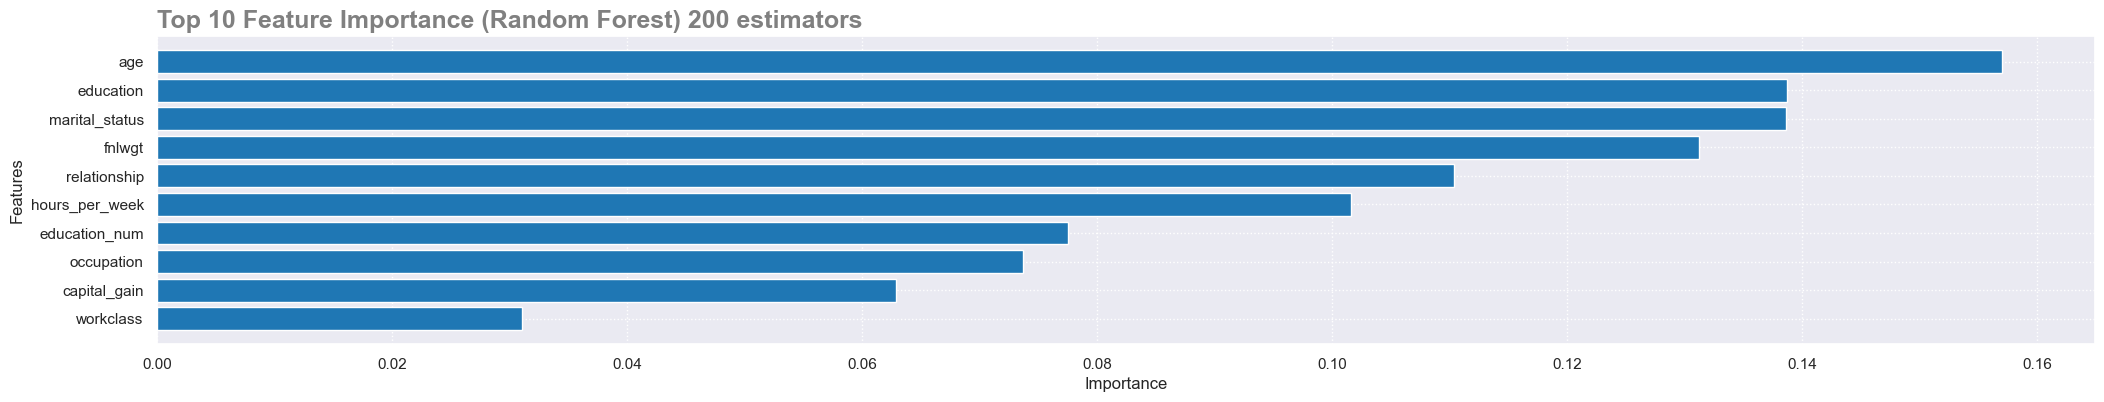

,Feature,Importance
0,age,0.157058
9,education,0.138743
10,marital_status,0.138623
1,fnlwgt,0.131210
11,relationship,0.110435
5,hours_per_week,0.101648
2,education_num,0.077502
6,occupation,0.073681
3,capital_gain,0.062891
7,workclass,0.031051


In [31]:
# Función para calcular los feature_importances (Random forest)
# path: ./modules/module_imbalanced.py
importance = imb_methods.calculate_rf_importance(df= df_balanced_smote,
                                                 target_col='income',
                                                 rf_estimators= 200,
                                                 plot= True)
importance[:10]

In [32]:
#matriz de correlación (ya la hicimos y la relación lineal es baja entre las numéricas)

In [33]:
mutual_info_results = imb_methods.calculate_mutual_info(df= df_balanced_smote, target_col='income')
mutual_info_results

,Feature,Mutual Information
10,marital_status,0.278405
11,relationship,0.247970
9,education,0.185410
0,age,0.148309
5,hours_per_week,0.138351
1,fnlwgt,0.104236
6,occupation,0.099665
3,capital_gain,0.088328
13,genre,0.086579
2,education_num,0.080100


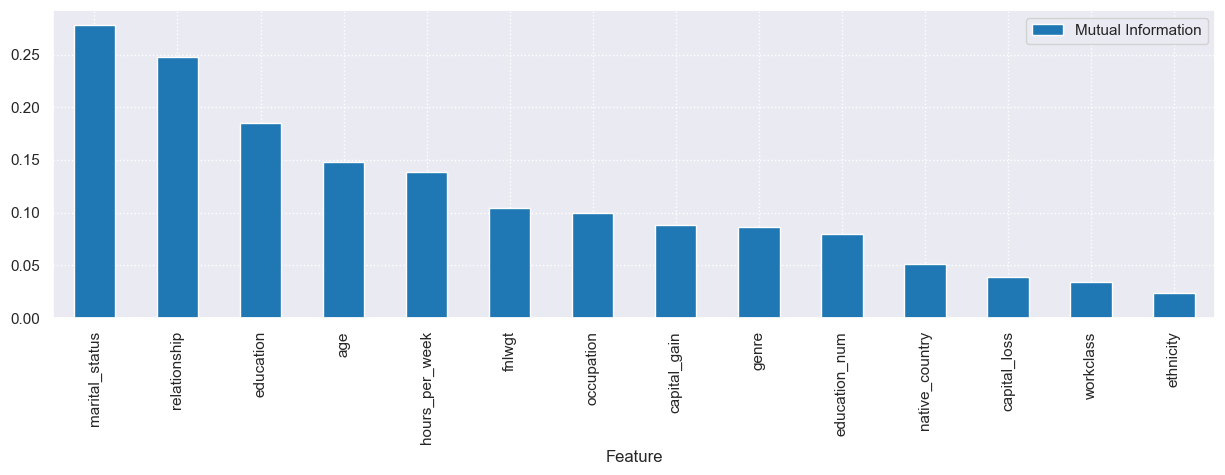

In [34]:
mutual_info_results.plot(kind='bar', x='Feature', y='Mutual Information', figsize=(15, 4))
plt.show()

In [35]:
selected_cols = ['age', 'hours_per_week', 'marital_status', 'relationship', 'education',
                 'occupation', 'capital_gain', 'capital_loss', 'income']
df_selected = df_balanced_smote[selected_cols]
df_selected[:3]

,age,hours_per_week,marital_status,relationship,education,occupation,capital_gain,capital_loss,income
0,39,40,never_married,not_in_family,bachelors,adm_clerical,2174,0,no
1,50,13,married_civ_spouse,husband,bachelors,exec_managerial,0,0,no
2,38,40,divorced,not_in_family,hs_grad,handlers_cleaners,0,0,no


<div class="alert alert-success">
    <b style="font-size: 1.5em;"> ✅ Columnas elegidas</b>
    <p><b>Feature importances <i>(con Random forest)</i></b>: Feature Importance evalúa cómo una variable ayuda a dividir el dataset en un modelo de árbol. Da prioridad a la variables numéricas <code>age, fnlwgt(descartada)</code> y a las categóricas <code>education, marital_status, relationship</code>.<br>En general, el peso está bien distribuido entre las columnas. Entre las restantes hay varias que aportan al modelo pero en menor proporción.</p>
    <p><b>Mutual info</b>: Mide la dependencia entre las variables de de entrenamiento y target. Se observa que el resultado de mucho más peso a las variables categóricas <code>marital_status, relationship, education</code>.</p>
    <p>Ambas metodologías coinciden en las tres variables relevantes, apareciendo en sus respectivos top 5. Basándonos en el contexto, dado que hay evidencia de correlación por análisis previos entre <code>occupation</code>. Las columnas elegidas son las siguientes:</p>
    <ul>
        <li><i>marital_status, age, relationship, fnlwgt, education, hours_per_week, occupation(imputada en el notebook anterior)</i></li>
    </ul> 
</div>
<div class="alert alert-info">
    <b style="font-size: 1.5em;">💡 Sumario y Reflexión: SMOTE y la selección de columnas relevantes</b>
    <p>Durante este proceso de balanceo hemos abordado dos enfoques principales: <b>SMOTE</b> y <b> balanceo por subsets</b>. Finalmente, se eligimos SMOTE debido a su mejor desempeño en métricas tales como: <i>F1-score, recall y accuracy</i>. Posteriormente, realizamos una selección de columnas relevantes utilizando <b>Feature Importances (Random Forest)</b>  sumado a un <b>Mutual Information</b>.<br><br> La selección final está basada en la visualización y desempeño de ambas metodologías. Finalmente seleccionando las columnas en común.</p>
    <p>Justificación del uso de esta técnica: <b>(SMOTE + selección de columnas relevantes)</b>:</p>
    <ul>
        <li>El análisis de <i>Feature Importances</i> + <i>Mutual Information</i> ha permitido seleccionar columnas con fuerte correlación y dependencia a la variable target.</li>
        <li>El enfoque combinado ayudó a minimizar la redundancia y evitar así la multicolinealidad de variables, priorizando únicamente a las columnas más relevantes.</li>
        <li>Evitamos introducir ruido excesivo, ya que las variables seleccionadas fueron evaluadas y confirmadas en su impacto.</li>
    </ul>
    <p><b>Reflexión adicional:</b> A pesar de haber descartado el SMOTE + PCA, por lo general esta técnica tiende a ser lo suficientemente sólida como para implementarse en la mayoría de los casos, aunque no ha sido esta la ocación. La utilidad de ésta técnica tiene los siguientes beneficios:</p>
    <ul>
        <li>Reduce el ruido introducido por los datos sintéticos generados por SMOTE.</li>
        <li>Identifica combinaciones lineales de variables que expliquen la mayor variabilidad de los datos balanceados.</li>
    </ul>
</div>

## (2.4) Problema con fnlwgt

<div class="alert alert-warning">
    <b style="font-size: 1.5em;">⚠️ Problemas con la columna fnlwgt⚠️</b>
    <p>Durante el análisis exploratorio en pasos anteriores encontramos que una de las variables más importantes en el análisis inicial fue <i>fnlwgt</i>. Sin embargo, al planear el despliegue del modelo surgió una preocupación:</p> 
    <ul>
        <li>El usuario no tendría acceso a esta cifra <i>(fnlwgt)</i> sin los datos y procesos específicos del dataset original. Por esta razón, aceptamos el reto de crear un modelo capaz de predecir este valor, dada su importancia en el desempeño del modelo principal.</li>
    </ul>
    <p><b>Estrategia</b>:</p>
    <ul>
        <li>Se exploraron varios algoritmos: <i>Random Forest Regressor, XGBoost, LightGBM, SVR</i> junto con una estrategia de Modelos de ensamble<i>(stacking)</i> combinando varios de los anteriores.</li>
    </ul>
    <p>Todos estos métodos fueron optimizados mediante la búsqueda de hiperparámetros (GridSearchCV) y ajustes adicionales como:</p>
    <ul>
        <li>PCA para reducción de dimensionalidad.
        <li>Incorporación de variables derivadas como <code>capital_net</code> <i>(basado en capital_gain y capital_loss).</i></li>
        <li>Variantes con distintos conjuntos de columnas consideradas importantes.</li>
    </ul>
    <p>A pesar de las múltiples iteraciones con distintos métodos, los resultados en todos los casos tuvieron un desmempeño poco aceptable</p>
    <ul>
        <li>La métricas: <b>R², MAE y RMSE</b> (haciendo incapié en la primera) reflejaron un modelo incapaz de generalizar la complejidad de <i>fnlwgt</i></li>
    </ul>
    <p><b>reflexión</b>: A pesar de haber tenido indicios de que esta variable podría ser problemática desde el principio del análisis exploratorio, ignoramos tal evidencia y continuamos con el análisis, aceptando el reto de enfrentarse a predecir esta variable.</p>
    <ol>
        <li>Esta es una prueba sobre la importancia sobre evitar ignorar indicios que los datos nos dan al princpio del EDA, y que no todos los valores importantes en un análisis inicial son predicibles en un contexto práctico. fnlwgt, aunque relevante para predecir income, no fue posible de modelar con la precisión deseada <i>(incluso tras extensos ajustes)</i></li>
        <li>A veces es más eficiente reevaluar y rediseñar estrategias en lugar de insistir en una solución que no es factible en el contexto práctico.</li>
    </ol>
</div>
<div class="alert alert-info">
    <b style="font-size: 1.5em;">💭 Nueva estrategia</b>
    <p>Se descarta <code>fnlwgt</code>como variable en el modelo final que busca predecir <code>income</code>. Para compensar su ausencia, se agregarán más columnas presentes en las <b>feature importances</b> | <b>mutual information</b></p>
    <br>
    <p>Para contrarrestar la pérdida de <code>fnlwgt</code> evaluaremos diferentes instancias del df con las columnas más importantes:</p>
    <ul>
        <li> <b>df_no_capital</b>: sin agregar más columnas (total de 7)</li>
        <li> <b>df_capital_gain</b>: agregando otra feature importance con menos relevancia: <code>capital_gain</code> (total de 8)
        <li> <b>df_capital_net</b>: haciendo una columna nueva: <code>capital_net</code> <i>(direfencia entre capital_gain y capital_loss)</i> (total de 8)</li>
    </ul>
</div>

In [36]:
# solo capital gain
df_capital_gain = df_selected.drop(columns= 'capital_loss') 

# capital net
df_capital_net = df_selected.copy()
df_capital_net['capital_net'] = df_selected['capital_gain'] - df_selected['capital_loss']
df_capital_net = df_capital_net.drop(columns= ['capital_gain', 'capital_loss'])
df_capital_net = (df_capital_net
                  [[col for col in df_capital_net.columns 
                    if col != 'income'] + ['income']]) # 'income' al final

# sin capital
df_no_capital = df_capital_net.drop(columns= 'capital_net')

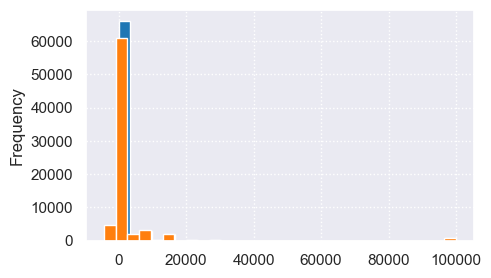

In [37]:
df_capital_gain['capital_gain'].plot(kind='hist', bins= 30, figsize= (5, 3))
df_capital_net['capital_net'].plot(kind='hist', bins= 30, figsize= (5, 3))
plt.show()

In [38]:
# evaluación de df's
report_gain = imb_methods.evaluate_performance(df = df_capital_gain,
                                               target_col= 'income',
                                               use_pca= False,
                                               n_components= None,
                                               show_report= False)
report_gain


              precision    recall  f1-score   support

          no       0.85      0.82      0.83     11139
         yes       0.83      0.86      0.84     11138

    accuracy                           0.84     22277
   macro avg       0.84      0.84      0.84     22277
weighted avg       0.84      0.84      0.84     22277



,train,test
accuracy,0.946594,0.838264
f1_macro,0.946583,0.838199
f1_weighted,0.946583,0.838199
precision_macro,0.946951,0.838804
recall_macro,0.946594,0.838265


In [39]:
# evaluación de df's
datasets = {'capital_gain': df_capital_gain,
            'capital_net': df_capital_net,
            'no_capital': df_no_capital}

results_performance = imb_methods.evaluate_dfs(dfs= datasets, target_col= 'income', n_components= 5)

# visualizar resultados de forma fashion
pprint.pprint(results_performance)

Evaluando dataset: capital_gain without PCA
              precision    recall  f1-score   support

          no       0.85      0.82      0.83     11139
         yes       0.83      0.86      0.84     11138

    accuracy                           0.84     22277
   macro avg       0.84      0.84      0.84     22277
weighted avg       0.84      0.84      0.84     22277

Evaluando dataset: capital_gain with PCA
              precision    recall  f1-score   support

          no       0.84      0.81      0.83     11139
         yes       0.82      0.85      0.83     11138

    accuracy                           0.83     22277
   macro avg       0.83      0.83      0.83     22277
weighted avg       0.83      0.83      0.83     22277

Evaluando dataset: capital_net without PCA
              precision    recall  f1-score   support

          no       0.85      0.82      0.84     11139
         yes       0.83      0.86      0.84     11138

    accuracy                           0.84     22277


<div class="alert alert-info">
    <b style="font-size: 1.5em;">🔍 evaluación de performance</b>
    <ul>
        <li><code>capital_gain</code> y <code>capital_net</code> sin PCA tienen el mejor desempeño. Si bien sus métricas son similares, capital_gain tiene un punto más en el f1-score, el cual se podría maximizar aun más con un grid search en el entrenamiento con el modelo final</li>
        <li>El uso de PCA no mejora el modelo; dehecho se degrada el desmpeño al usarlo. Se descartará su implementación en el modelo final</li>
        <li>El dataset sin columnas agregadas es el que tiene el desempeño más bajo, lo que confirma que las variables agregadas aportan información al modelo
     <br>
     <p>continuaremos con el dataset con el cálculo de capital neto <i>(diferencia entre capital_gain y capital_loss)</i></p>
</div>

In [40]:
df_selected = df_capital_net.copy()

## (2.5) Outliers

In [41]:
#outliers con z-score
df_z_outliers, df_z_no_outliers = initial_exp.outliers_zcore(df= df_selected, threshold= 3)

Z-score outliers count: 2152
threshold: 3
Proporción de outliers (vs total de filas): 2.9


In [42]:
df_outliers_iqr, df_no_outliers_iqr = initial_exp.outliers_iqr(df= df_selected)

Detección de outliers con IQR: 22424 filas
Proporción de outliers (vs total de filas): 30.2


In [43]:
load.save_dataframe(df= df_selected, file_name= 'adult_with_outliers', dir= 'clean')
load.save_dataframe(df= df_no_outliers_iqr, file_name= 'adult_without_outliers', dir= 'clean')

SUCCESS: File adult_with_outliers.csv saved in ../data/clean
SUCCESS: File adult_without_outliers.csv saved in ../data/clean


<div class="alert alert-info">
    <b style="font-size: 1.5em;"> 🔍 Selección de dataset para entrenamiento (con | sin outliers)</b>
    <p><b>Validación empírica</b>: Los resultados mostraron que <i>IQR</i> detecta un <b>15%</b> de filas como outliers, mientras que el <i>z-score</i> el <b>~3%</b>. Esto sugiere que el primero ha capturado mayor variabilidad <i>(potenicalmente legítima)</i></p>
    <ul>
        <li>Se ha descartado el <i>z-score</i> (investigando más al respecto) tiende a ser más útil cuando el dataset tiene forma gaussiana <i>(normal)</i>, y tiende a ser <b>menos preciso</b> con datasets que no cumplen con esta característica.</li>
        <li>Por otro lado, el <i>IQR</i> es más adecuado para nuestro contexto de análisis, ya que no asume "normalidad" en los datos, y por tanto más robusto en estos casos.<br><i>Este es precisamente el comportamiento de las variables elegidas para el entrenamiento.</i></li>
        <ul>
            <li>El punto negativo es que el <i>IQR</i> tiende a "sobre-detectar" outliers en columnas con una gran variabilidad legítima <i>(el cuál es nuestro caso)</i></li></ul> 
            <li>Dado a este último punto; el cuál nos pone en desventaja, hemos decidido comenzar el entrenamiento del modelo con dos datasets: (con outliers y sin outliers)</li>
    </ul>
    <p><b>Estrategia</b>: Se hará un primer entrenamiento con un <code>Random Forest</code> con el objetivo de estudiar el desempeño de ambos modelos (con y sin outliers) centrándonos en métricas tales como: <i>F1-score, recall, accuracy, capacidad de generalización (usando un cv)</i></p>
    <ul>
        <li>Esto nos pondrá en ventaja para decidir el dataset con mejor desempeño. Sin tomar desiciones arbitrarias</li>
        <li>Finalmente, con el dataset elegido. Se hará un entrenamiento final buscando los mejores parámetros (Grid search)</li>
    </ul>
</div>
<div class="alert alert-info">
    <b style="font-size: 1.5em;">💭 esta estrategia en otros contextos </b>
    <p>implementación de esta estrategia en un contexto diferente: <br><i>Dada la situación donde nos enfrentamos a un dataset con una cantidad masiva de datos (millones de filas) se podría implementar esta misma estrategia, pero esta vez haciendo un muestreo estratificado para reducir el tiempo del experimento.<br><br>La parte importante será obtener un muestreo tal que sea representativo del dataset original, logrando generalizar sin problemas</p>
    <ul>
        <li>Como regla general al menos 10k ocurrencias tienden a ser suficientes para entrenar un modelo decente, dependiendo de la complejidad del dataset</li>
        <li>Esta estrategía podría ser una buena práctica en casos específicos. Donde los recursos computacionales son limitados o el dataset sea masivo. Si por ejemplo tenemos <b>~74k</b> filas, no sería necesario el muestreo, dado que el tamaño del dataset es manejable</li>
        <li>La comparación entre datasets (con y sin outliers) debería hacerse con el dataset completo, para así obtener resultados más precisos y evitar que el muestro introduzca variabilidad no esperada</li></i>
    </ul>
</div>